In [1]:
#kernel lightgbm
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib
from matplotlib import pyplot as plt

In [2]:
import sys
print(sys.executable)

C:\Users\scott\Anaconda3\envs\lightgbm\python.exe


In [ ]:
import DataPrep


In [14]:
import error_evaluation

In [ ]:
from azureml.core import Workspace
from azureml.core import Experiment

In [ ]:
ws = Workspace.get('scottchamlworkspace', subscription_id='7d2d1e21-7718-415a-b98e-780ef0b02ad5', resource_group='mlworkspacerg')
ws.write_config()

In [ ]:
X_Above_test, X_Above_train, y_Above_test, y_Above_train, X_Near_test, X_Near_train, y_Near_test, y_Near_train, X_Below_test, X_Below_train, y_Below_test, y_Below_train = DataPrep.prep_day1_danger_train_test('../Data/V1.1FeaturesWithLabels30Days20131201To20180430.csv', ignore_extreme=True, oversample=False)

In [2]:
pd.__version__

'0.24.2'

In [2]:
X_Above_train = pd.read_pickle('E:/Temp/combinedtsfreshandseries_X_train.pkl')
X_Above_test = pd.read_pickle('E:\Temp\combinedtsfreshandseries_X_test.pkl')
y_Above_test = pd.read_pickle('E:\Temp\combinedtsfreshandseries_y_test.pkl')
y_Above_train = pd.read_pickle('E:\Temp\combinedtsfreshandseries_y_train.pkl')

In [3]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

1    115779
2     66231
0     64389
3     13353
Name: o_Day1DangerAboveTreeline, dtype: int64

In [4]:
from imblearn.over_sampling import ADASYN

In [5]:
ada = ADASYN(random_state=42, n_jobs=8)
X_res, y_res = ada.fit_resample(X_Above_train, y_Above_train['o_Day1DangerAboveTreeline'])

In [25]:
idx = np.random.choice(X_res.shape[0], 100000, replace=False)
sample_X = X_res[idx]
sample_y = y_res[idx]

In [31]:
y_Above_test['o_Day1DangerAboveTreeline'].head()

2017-03-28-37044841054338816-17    0
2017-03-29-37044841054338816-17    1
2017-03-30-37044841054338816-17    0
2017-03-31-37044841054338816-17    0
2017-04-01-37044841054338816-17    2
Name: o_Day1DangerAboveTreeline, dtype: int64

In [26]:
np.save('E:/Temp/X_train_sample_tsfresh_ADASYN.npy', sample_X)
np.save('E:/Temp/y_train_sample_tsfresh_ADASYN.npy', sample_y)

In [32]:
#np.save('E:/Temp/X_test_tsfresh.npy', X_Above_test)
np.save('E:/Temp/y_test_tsfresh.npy', y_Above_test['o_Day1DangerAboveTreeline'])

In [7]:
pd.Series(y_res).value_counts()

0    119146
3    117600
1    115779
2    112291
dtype: int64

In [16]:
y_Above_train['Date'].dt.year.value_counts()

2018    63622
2015    61029
2014    60684
2016    53797
2017    13291
2013     7329
Name: Date, dtype: int64

In [17]:
y_Above_test['Date'].dt.year.value_counts()

2017    46152
2016    16711
Name: Date, dtype: int64

In [5]:
tmp = pd.DataFrame(X_Above_train, columns = X_Above_test.columns)
X_Above_train_contenental = tmp[tmp['c_IsContenentalSnowpack'] == 1]
tmp2 = pd.Series(y_Above_train)
y_Above_train_contenental = tmp2[tmp['c_IsContenentalSnowpack'] == 1]

ValueError: Wrong number of items passed 17, placement implies 259752

In [ ]:
X_Above_test_contenental = X_Above_test[X_Above_test['c_IsContenentalSnowpack']==1]
y_Above_test_contenental = y_Above_test[X_Above_test['c_IsContenentalSnowpack']==1]
X_Above_test = X_Above_test_contenental
y_Above_test = y_Above_test_contenental

In [ ]:
exp = Experiment(workspace=ws, name='lightgbm-exp1')

In [ ]:
run = exp.start_logging()

In [ ]:
class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 1
class_weights_dict[2] = 1
class_weights_dict[3] = 20

In [ ]:
X_Above_test = pd.read_pickle('E:/Temp/X_test.pkl')
y_Above_test = pd.read_pickle('E:/Temp/y_test.pkl')

X_Above_train = np.load('E:/Temp/X_train_ADASYN.npy')
y_Above_train = np.load('E:/Temp/y_train_ADASYN.npy')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = MinMaxScaler(copy=True, feature_range=(0,1))
scaler.fit(X_Above_train)
X_Above_train_scaled = scaler.transform(X_Above_train)
X_Above_test_scaled = scaler.transform(X_Above_test.values)

In [91]:
#oosting_type": "goss", "colsample_bytree": 0.3966666666666666, "learning_rate": 0.09473736842105263, "max_bin": 120, "max_depth": 3, "min_child_weight": 1, "min_data_in_leaf": 0.010353793103448278, "min_split_gain": 0.21052631578947367, "n_estimators": 200, "num_leaves": 29, "reg_alpha": 0.3684210526315789, "reg_lambda": 0.2631578947368421, "subsample": 1
gbmgpu = lgb.LGBMClassifier(boosting_type="goss", 
                            device_type='gpu', 
                            colsample_bytree=0.4, 
                            learning_rate=0.01, 
                            max_bin=120, 
                            max_depth=3,
                            min_child_weight=1,
                            min_data_in_leaf=0,
                            min_split_gain=0.21,
                            n_estimators=1600,
                            num_leaves=29,
                            reg_alpha=0.3684210526315789,
                            reg_lambda=0.2631,
                            subsample=1
                            
                        
                           )

In [89]:
gbmgpu = lgb.LGBMClassifier(boosting_type="gbdt", 
                            #device_type='gpu', 
                            colsample_bytree=0.1, 
                            learning_rate=0.08947473684210526, 
                            max_bin=310, 
                            max_depth=2,
                            min_child_weight=6,
                            min_data_in_leaf=0,
                            min_split_gain=0.7894736842105263,
                            n_estimators=800,
                            num_leaves=32,
                            reg_alpha=0.3684210526315789,
                            reg_lambda=0.47368421052631576,
                            subsample=0.6931578947368422
                           )

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='auc', 
                            device_type='gpu', 
                            learning_rate=.05, 
                            num_class=4, 
                            num_leaves=250,
                            feature_fraction=.75,
                            bagging_fraction=.2,                            
                            #min_child_samples=120, 
                            #min_child_weight=.1,
                            n_estimators=500,
                            #num_boost_round=1000,
                            class_weight=class_weights_dict
                           )

In [ ]:
from imblearn.ensemble import RUSBoostClassifier


In [ ]:
run.log(name="Model Type", value="LGBMClassifier")
run.log(name="Imbalance Correction", value="ADASYN")

In [11]:
y_Above_train.head()

,o_Day1DangerAboveTreeline,o_Cornices_Likelihood,o_Glide_Likelihood,o_LooseDry_Likelihood,o_LooseWet_Likelihood,o_PersistentSlab_Likelihood,o_DeepPersistentSlab_Likelihood,o_StormSlabs_Likelihood,o_WetSlabs_Likelihood,o_WindSlab_Likelihood,Lat,Lon,UnifiedRegion,Date,Season,IsCriticalPoint,Forecast
2014-03-08-37044841054338813-14,2,no-data,no-data,no-data,no-data,1-possible,no-data,2-likely,no-data,no-data,37.044847,-105.433882,Sangre de Cristo,2014-03-08,13-14,False,Considerable
2014-03-09-37044841054338813-14,2,no-data,no-data,no-data,no-data,1-possible,no-data,no-data,no-data,1-possible,37.044847,-105.433882,Sangre de Cristo,2014-03-09,13-14,False,Considerable
2014-03-10-37044841054338813-14,1,no-data,no-data,no-data,no-data,1-possible,no-data,no-data,no-data,no-data,37.044847,-105.433882,Sangre de Cristo,2014-03-10,13-14,False,Moderate
2014-03-11-37044841054338813-14,1,no-data,no-data,no-data,no-data,1-possible,no-data,no-data,no-data,no-data,37.044847,-105.433882,Sangre de Cristo,2014-03-11,13-14,False,Moderate
2014-03-12-37044841054338813-14,1,no-data,no-data,no-data,no-data,1-possible,no-data,no-data,no-data,no-data,37.044847,-105.433882,Sangre de Cristo,2014-03-12,13-14,False,Moderate


In [66]:
X_res_df = pd.DataFrame(X_res, columns = X_Above_train.columns)
y_res_df = pd.Series(y_res)

In [67]:
y_res_df.head()

0    2
1    2
2    1
3    1
4    1
dtype: int64

In [92]:
%%time
yColumns = ['o_Day1DangerAboveTreeline']
bst = gbmgpu.fit(X_res, 
        y_res, 
        eval_set=[(X_Above_test, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=20,
        
        )

[1]	valid_0's multi_logloss: 1.39257
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 1.38966
[3]	valid_0's multi_logloss: 1.38706
[4]	valid_0's multi_logloss: 1.38405
[5]	valid_0's multi_logloss: 1.38125
[6]	valid_0's multi_logloss: 1.37896
[7]	valid_0's multi_logloss: 1.37603
[8]	valid_0's multi_logloss: 1.37358
[9]	valid_0's multi_logloss: 1.37106
[10]	valid_0's multi_logloss: 1.36883
[11]	valid_0's multi_logloss: 1.36668
[12]	valid_0's multi_logloss: 1.36427
[13]	valid_0's multi_logloss: 1.36184
[14]	valid_0's multi_logloss: 1.35918
[15]	valid_0's multi_logloss: 1.35651
[16]	valid_0's multi_logloss: 1.35403
[17]	valid_0's multi_logloss: 1.35138
[18]	valid_0's multi_logloss: 1.3487
[19]	valid_0's multi_logloss: 1.3463
[20]	valid_0's multi_logloss: 1.34389
[21]	valid_0's multi_logloss: 1.34121
[22]	valid_0's multi_logloss: 1.33889
[23]	valid_0's multi_logloss: 1.3367
[24]	valid_0's multi_logloss: 1.33485
[25]	valid_0's multi_logloss: 1.33272


[213]	valid_0's multi_logloss: 1.11348
[214]	valid_0's multi_logloss: 1.11293
[215]	valid_0's multi_logloss: 1.11233
[216]	valid_0's multi_logloss: 1.11187
[217]	valid_0's multi_logloss: 1.11168
[218]	valid_0's multi_logloss: 1.11087
[219]	valid_0's multi_logloss: 1.11044
[220]	valid_0's multi_logloss: 1.10954
[221]	valid_0's multi_logloss: 1.10909
[222]	valid_0's multi_logloss: 1.10856
[223]	valid_0's multi_logloss: 1.10785
[224]	valid_0's multi_logloss: 1.10715
[225]	valid_0's multi_logloss: 1.10635
[226]	valid_0's multi_logloss: 1.10596
[227]	valid_0's multi_logloss: 1.10532
[228]	valid_0's multi_logloss: 1.10478
[229]	valid_0's multi_logloss: 1.10432
[230]	valid_0's multi_logloss: 1.10386
[231]	valid_0's multi_logloss: 1.10342
[232]	valid_0's multi_logloss: 1.10266
[233]	valid_0's multi_logloss: 1.10174
[234]	valid_0's multi_logloss: 1.10124
[235]	valid_0's multi_logloss: 1.10053
[236]	valid_0's multi_logloss: 1.1
[237]	valid_0's multi_logloss: 1.09944
[238]	valid_0's multi_logloss

[424]	valid_0's multi_logloss: 1.02794
[425]	valid_0's multi_logloss: 1.02751
[426]	valid_0's multi_logloss: 1.02724
[427]	valid_0's multi_logloss: 1.02739
[428]	valid_0's multi_logloss: 1.02706
[429]	valid_0's multi_logloss: 1.02672
[430]	valid_0's multi_logloss: 1.0265
[431]	valid_0's multi_logloss: 1.02627
[432]	valid_0's multi_logloss: 1.02582
[433]	valid_0's multi_logloss: 1.02556
[434]	valid_0's multi_logloss: 1.02535
[435]	valid_0's multi_logloss: 1.02523
[436]	valid_0's multi_logloss: 1.02534
[437]	valid_0's multi_logloss: 1.02533
[438]	valid_0's multi_logloss: 1.02517
[439]	valid_0's multi_logloss: 1.02541
[440]	valid_0's multi_logloss: 1.02503
[441]	valid_0's multi_logloss: 1.02523
[442]	valid_0's multi_logloss: 1.02492
[443]	valid_0's multi_logloss: 1.02465
[444]	valid_0's multi_logloss: 1.02438
[445]	valid_0's multi_logloss: 1.024
[446]	valid_0's multi_logloss: 1.02371
[447]	valid_0's multi_logloss: 1.02336
[448]	valid_0's multi_logloss: 1.02311
[449]	valid_0's multi_loglos

[634]	valid_0's multi_logloss: 0.992437
[635]	valid_0's multi_logloss: 0.992287
[636]	valid_0's multi_logloss: 0.992047
[637]	valid_0's multi_logloss: 0.991744
[638]	valid_0's multi_logloss: 0.99169
[639]	valid_0's multi_logloss: 0.991506
[640]	valid_0's multi_logloss: 0.991435
[641]	valid_0's multi_logloss: 0.991432
[642]	valid_0's multi_logloss: 0.991597
[643]	valid_0's multi_logloss: 0.991493
[644]	valid_0's multi_logloss: 0.991281
[645]	valid_0's multi_logloss: 0.991053
[646]	valid_0's multi_logloss: 0.990856
[647]	valid_0's multi_logloss: 0.990831
[648]	valid_0's multi_logloss: 0.990533
[649]	valid_0's multi_logloss: 0.990509
[650]	valid_0's multi_logloss: 0.990231
[651]	valid_0's multi_logloss: 0.990043
[652]	valid_0's multi_logloss: 0.989859
[653]	valid_0's multi_logloss: 0.989739
[654]	valid_0's multi_logloss: 0.989633
[655]	valid_0's multi_logloss: 0.989493
[656]	valid_0's multi_logloss: 0.989313
[657]	valid_0's multi_logloss: 0.989039
[658]	valid_0's multi_logloss: 0.988881
[

[840]	valid_0's multi_logloss: 0.968244
[841]	valid_0's multi_logloss: 0.968014
[842]	valid_0's multi_logloss: 0.968041
[843]	valid_0's multi_logloss: 0.968039
[844]	valid_0's multi_logloss: 0.96801
[845]	valid_0's multi_logloss: 0.967989
[846]	valid_0's multi_logloss: 0.967976
[847]	valid_0's multi_logloss: 0.967994
[848]	valid_0's multi_logloss: 0.967893
[849]	valid_0's multi_logloss: 0.967966
[850]	valid_0's multi_logloss: 0.967885
[851]	valid_0's multi_logloss: 0.967859
[852]	valid_0's multi_logloss: 0.967706
[853]	valid_0's multi_logloss: 0.967675
[854]	valid_0's multi_logloss: 0.967411
[855]	valid_0's multi_logloss: 0.967348
[856]	valid_0's multi_logloss: 0.96714
[857]	valid_0's multi_logloss: 0.966963
[858]	valid_0's multi_logloss: 0.966684
[859]	valid_0's multi_logloss: 0.966476
[860]	valid_0's multi_logloss: 0.966443
[861]	valid_0's multi_logloss: 0.966403
[862]	valid_0's multi_logloss: 0.966169
[863]	valid_0's multi_logloss: 0.965971
[864]	valid_0's multi_logloss: 0.965776
[8

[1045]	valid_0's multi_logloss: 0.952791
[1046]	valid_0's multi_logloss: 0.952739
[1047]	valid_0's multi_logloss: 0.952672
[1048]	valid_0's multi_logloss: 0.952625
[1049]	valid_0's multi_logloss: 0.95261
[1050]	valid_0's multi_logloss: 0.952592
[1051]	valid_0's multi_logloss: 0.952447
[1052]	valid_0's multi_logloss: 0.952493
[1053]	valid_0's multi_logloss: 0.952259
[1054]	valid_0's multi_logloss: 0.952181
[1055]	valid_0's multi_logloss: 0.952149
[1056]	valid_0's multi_logloss: 0.952105
[1057]	valid_0's multi_logloss: 0.952023
[1058]	valid_0's multi_logloss: 0.951964
[1059]	valid_0's multi_logloss: 0.951952
[1060]	valid_0's multi_logloss: 0.951886
[1061]	valid_0's multi_logloss: 0.951758
[1062]	valid_0's multi_logloss: 0.951611
[1063]	valid_0's multi_logloss: 0.951504
[1064]	valid_0's multi_logloss: 0.951377
[1065]	valid_0's multi_logloss: 0.95118
[1066]	valid_0's multi_logloss: 0.9511
[1067]	valid_0's multi_logloss: 0.951085
[1068]	valid_0's multi_logloss: 0.951077
[1069]	valid_0's mul

[1246]	valid_0's multi_logloss: 0.941575
[1247]	valid_0's multi_logloss: 0.941588
[1248]	valid_0's multi_logloss: 0.941637
[1249]	valid_0's multi_logloss: 0.941505
[1250]	valid_0's multi_logloss: 0.9414
[1251]	valid_0's multi_logloss: 0.941212
[1252]	valid_0's multi_logloss: 0.941231
[1253]	valid_0's multi_logloss: 0.941125
[1254]	valid_0's multi_logloss: 0.940985
[1255]	valid_0's multi_logloss: 0.940859
[1256]	valid_0's multi_logloss: 0.940733
[1257]	valid_0's multi_logloss: 0.940632
[1258]	valid_0's multi_logloss: 0.940578
[1259]	valid_0's multi_logloss: 0.940305
[1260]	valid_0's multi_logloss: 0.940258
[1261]	valid_0's multi_logloss: 0.940194
[1262]	valid_0's multi_logloss: 0.940019
[1263]	valid_0's multi_logloss: 0.939927
[1264]	valid_0's multi_logloss: 0.940069
[1265]	valid_0's multi_logloss: 0.939959
[1266]	valid_0's multi_logloss: 0.940097
[1267]	valid_0's multi_logloss: 0.940027
[1268]	valid_0's multi_logloss: 0.939705
[1269]	valid_0's multi_logloss: 0.939646
[1270]	valid_0's m

[1447]	valid_0's multi_logloss: 0.932364
[1448]	valid_0's multi_logloss: 0.932325
[1449]	valid_0's multi_logloss: 0.932198
[1450]	valid_0's multi_logloss: 0.932184
[1451]	valid_0's multi_logloss: 0.932137
[1452]	valid_0's multi_logloss: 0.932226
[1453]	valid_0's multi_logloss: 0.932526
[1454]	valid_0's multi_logloss: 0.932492
[1455]	valid_0's multi_logloss: 0.932419
[1456]	valid_0's multi_logloss: 0.93248
[1457]	valid_0's multi_logloss: 0.932504
[1458]	valid_0's multi_logloss: 0.932487
[1459]	valid_0's multi_logloss: 0.932428
[1460]	valid_0's multi_logloss: 0.932442
[1461]	valid_0's multi_logloss: 0.932451
Early stopping, best iteration is:
[1441]	valid_0's multi_logloss: 0.932071
Wall time: 7min 19s


In [93]:
resultAbove = gbmgpu.predict(X_Above_test, gbmgpu.best_iteration_)
m = gbmgpu

In [94]:



best_preds = [np.argmax(line) for line in resultAbove]
preds = best_preds
best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerNearTreeline'])
#only look at critical points
#y_Above_test_crit = y_Above_test[y_Above_test['IsCriticalPoint']==True]
#X_Above_test_crit = X_Above_test.loc[y_Above_test_crit.index, :]
#preds_crit = m.predict(scaler.transform(X_Above_test_crit.values))
#split in to forecast types
#X_Above_test_cont = X_Above_test[X_Above_test['c_IsContenentalSnowpack']==True]
#y_Above_test_cont = y_Above_test.loc[X_Above_test_cont.index, :]

#X_Above_test_coast = X_Above_test[X_Above_test['c_IsCoastalSnowpack']==True]
#y_Above_test_coast = y_Above_test.loc[X_Above_test_coast.index, :]

#preds_cont = m.predict(scaler.transform(X_Above_test_cont.values))
#preds_coast = m.predict(scaler.transform(X_Above_test_coast.values))
y_Above_test['Prediction'] = preds
#remove synthetic regions from the evaluation

synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
y_Above_test = y_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]
preds = y_Above_test['Prediction']

Accuracy: 0.5853681816012599
Classification Report
              precision    recall  f1-score   support

           0       0.36      0.48      0.41      4979
           1       0.72      0.63      0.68     32996
           2       0.50      0.59      0.54     19113
           3       0.45      0.40      0.42      5775

   micro avg       0.59      0.59      0.59     62863
   macro avg       0.51      0.53      0.51     62863
weighted avg       0.60      0.59      0.59     62863

Normalized confusion matrix
Confusion matrix, without normalization


NameError: name 'y_Above_test_crit' is not defined

<Figure size 432x288 with 0 Axes>

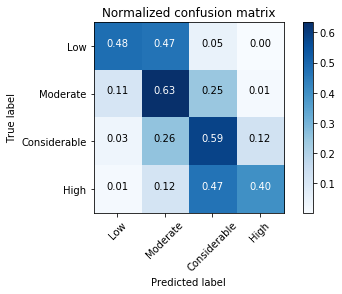

<Figure size 432x288 with 0 Axes>

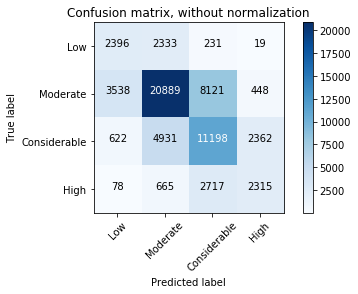

<Figure size 432x288 with 0 Axes>

In [95]:

report_all = error_evaluation.evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], preds)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], preds)
plt.figure()
figure_all_norm = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                                                         title='Normalized confusion matrix')

plt.figure()
figure_all = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Confusion matrix, without normalization')
plt.figure()
report_crit = error_evaluation.evaluateSingleClassShort(y_Above_test_crit['o_Day1DangerAboveTreeline'], preds_crit)
cnf_matrix_crit = confusion_matrix(y_Above_test_crit['o_Day1DangerAboveTreeline'], preds_crit)

figure_crit_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Critcial Point Normalized confusion matrix')
plt.figure()
figure_crit = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Critcial Point Confusion matrix, without normalization')

plt.figure()
report_cont = error_evaluation.evaluateSingleClassShort(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)
cnf_matrix_cont = confusion_matrix(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)

figure_cont_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Continental Forecast Normalized confusion matrix')
plt.figure()
figure_cont = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Continental Forecast Confusion matrix, without normalization')

plt.figure()
report_coast = error_evaluation.evaluateSingleClassShort(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)
cnf_matrix_coast = confusion_matrix(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)

figure_coast_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Coastal Forecast Normalized confusion matrix')
plt.figure()
figure_coast = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Coastal Forecast Confusion matrix, without normalization')
plt.show()

In [ ]:
#mapping = {0:'Considerable', 1:'High', 2:'Low', 3:'Moderate'}
#best_preds_df = best_preds_df.replace({'o_Day1DangerNearTreeline': mapping})
#best_preds_df['o_Day1DangerNearTreeline'].head()

In [ ]:
run.log(name='Micro Avg F1', value=report_all['micro avg']['f1-score'])

run.log_image(name='All Regions', plot=figure_all_norm)
run.log_image(name='Critical Points', plot=figure_crit_norm)
run.log_image(name='Contenental Points', plot=figure_cont_norm)
run.log_image(name='Coastal Points', plot=figure_coast_norm)

run.log(name='All Low f1', value=report_all['0']['f1-score'])
run.log(name='All Moderate f1', value=report_all['1']['f1-score'])
run.log(name='All Considerable f1', value=report_all['2']['f1-score'])
run.log(name='All High f1', value=report_all['3']['f1-score'])
run.log(name='All Micro Avg F1', value=report_all['micro avg']['f1-score'])

run.log(name='Crit Low f1', value=report_crit['0']['f1-score'])
run.log(name='Crit Moderate f1', value=report_crit['1']['f1-score'])
run.log(name='Crit Considerable f1', value=report_crit['2']['f1-score'])
run.log(name='Crit High f1', value=report_crit['3']['f1-score'])
run.log(name='Crit Micro Avg F1', value=report_crit['micro avg']['f1-score'])

run.log(name='Cont Low f1', value=report_cont['0']['f1-score'])
run.log(name='Cont Moderate f1', value=report_cont['1']['f1-score'])
run.log(name='Cont Considerable f1', value=report_cont['2']['f1-score'])
run.log(name='Cont High f1', value=report_cont['3']['f1-score'])
run.log(name='Cont Micro Avg F1', value=report_cont['micro avg']['f1-score'])

run.log(name='Coast Low f1', value=report_coast['0']['f1-score'])
run.log(name='Coast Moderate f1', value=report_coast['1']['f1-score'])
run.log(name='Coast Considerable f1', value=report_coast['2']['f1-score'])
run.log(name='Coast High f1', value=report_coast['3']['f1-score'])
run.log(name='Coast Micro Avg F1', value=report_coast['micro avg']['f1-score'])

run.log(name='Parameters', value=gbmgpu.get_params())
run.complete()

In [ ]:
y_Above_test[yColumns].values[:10]

In [ ]:
#roc curve
from sklearn.preprocessing import LabelBinarizer
transformer = LabelBinarizer()
transformer.fit(y_Above_test[yColumns].values)
bins = transformer.transform(y_Above_test[yColumns].values)

In [ ]:
bins[:10]

In [ ]:
bins[:, 1]

In [ ]:
resultAbove_proba = gbmgpu.predict_proba(X_Above_test.values, gbmgpu.best_iteration_)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr3, tpr3, thresholds3 = roc_curve(bins[:,3], resultAbove_proba[:,3])
fpr2, tpr2, thresholds2 = roc_curve(bins[:,2], resultAbove_proba[:,2])
fpr1, tpr1, thresholds1 = roc_curve(bins[:,1], resultAbove_proba[:,1])
fpr0, tpr0, thresholds0 = roc_curve(bins[:,0], resultAbove_proba[:,0])

In [ ]:
pd.Series(resultAbove[:, 3]).min()

In [ ]:
fpr = fpr2
tpr = tpr2
thresholds = thresholds2
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='High')
#plt.plot(fpr2, tpr2, marker='+', label='Considerable')
#plt.plot(fpr1, tpr1, marker='.', label='Moderate')
#plt.plot(fpr0, tpr0, marker='.', label='Low')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

plt.legend(loc="lower right")
# show the plot
plt.show()

In [ ]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, t = precision_recall_curve(bins[:,2], resultAbove_proba[:,2])
plot_precision_recall_vs_threshold(p, r, t)

In [ ]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.5, .8],
    'num_leaves': [200, 350, 500],
    'feature_fraction': [.75, 1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],
    'class_weight': [None, 'balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print(run.get_portal_url())

In [ ]:
#X_Above_train, 
#y_Above_train, 
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_Above_train):
    print("%s %s" % (train, test))


In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [15, 31, 63]#, 127, 255, 511, 1023, 2047, 4095]
}
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="f1_micro", n_jobs=6, cv=tscv, verbose=10)

grid_result = grid_search.fit(X_Above_train, y_Above_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [63, 127, 255, 511, 1023]#, 2047, 4095]
}
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="f1_micro", n_jobs=4, cv=tscv, verbose=10)

grid_result = grid_search.fit(X_Above_train, y_Above_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_Above_train, classes=[0, 1, 2, 3])

In [ ]:
y_bin.shape

In [ ]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='auc', device_type='gpu', class_weight=class_weights_dict)
param_grid = {
    'learning_rate': [0.25],
    'bagging_fraction': [.2],
    'num_leaves': [200, 250],
    'n_estimators': [500],
    'min_child_samples': [1, 60, 120],
    #'min_child_weight': [.001, .01, .1],
    'feature_fraction': [.5, .75, .9]
}

grid_search = GridSearchCV(gbmgpu, param_grid, scoring="f1_micro", n_jobs=5, cv=tscv, verbose=10)

grid_result = grid_search.fit(X_Above_train, y_Above_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#above here

In [ ]:
importances = pd.Series(gbmgpu.feature_importances_)
out = pd.concat([pd.Series(X_Above_test.columns), importances], axis=1)

In [ ]:
out.columns = ['feature', 'importance']

In [ ]:
out.sort_values('importance',ascending=False)[:10]

In [ ]:
out[['feature', 'importance']].sort_values('importance',ascending=False)[:100].plot.barh()
plt.show()

In [ ]:
gbmgpu = lgb.LGBMClassifier(objective='auc', 
                            device_type='gpu', 
                            learning_rate=.05, 
                            num_class=4, 
                            num_leaves=250,
                            feature_fraction=.75,
                            bagging_fraction=.2,                            
                            #min_child_samples=120, 
                            #min_child_weight=.1,
                            n_estimators=500,
                            #num_boost_round=1000,
                            class_weight=class_weights_dict
                           )

In [ ]:
%%time
gbmgpu.fit(X_Above_train_contenental, 
        y_Above_train_contenental, 
        eval_set=[(X_Above_test_contenental.values, y_Above_test_contenental[yColumns].values.ravel())],
        early_stopping_rounds=20
        )